# Project: Ridge Regression & Kernel Ridge Regression

## Set-up and dataset download from Kaggle



Dataset for this project is available on https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data?select=dataset.csv

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sn
import math
import chardet # to check encoding of source file of data imported

# time, sys
import time
import sys

# to release memory
import gc

# Tools for reference Linear regression and Ridge Reg
from sklearn import linear_model
from sklearn.linear_model import Ridge

# One-hot enconding and ordinal encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing

# Apply transformations to columns
from sklearn.compose import make_column_transformer

# Tools for tracking learning curves and perform cross validation
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV

# with standard methods CV
from sklearn.model_selection import KFold

# For Kernel Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics

In [2]:
# download from kaggle
os.environ['KAGGLE_USERNAME'] = "stravij"
os.environ['KAGGLE_KEY'] = "69ba28f80a721a872976d2414a2d4d72"

!kaggle datasets download maharshipandya/-spotify-tracks-dataset

  0% 0.00/8.17M [00:00<?, ?B/s]
100% 8.17M/8.17M [00:00<00:00, 95.3MB/s]


In [3]:
# rename file
old_name = r"/content/-spotify-tracks-dataset.zip"
new_name = r"/content/dataset.zip"
os.rename(old_name, new_name)
# in alternative also mv

# unpack zip
!unzip dataset.zip -d data

Archive:  dataset.zip
  inflating: data/dataset.csv        


Import dataset

In [4]:
# set name of dataset
lab_data='data/dataset.csv'

# check the encoding type and import dataset
is_ench = False # True if encoding is needed
if is_ench == True:
  with open(lab_data, 'rb') as f:
      result = chardet.detect(f.read())  # read or readline if the file is large
  data = pd.read_csv(lab_data, encoding=result['encoding'])
else:
  data = pd.read_csv(lab_data)

# #remove first colum
data = data.iloc[:, 1:]

# show first rows
data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Dataset preparation

### Dataset cleaning


In [5]:
# check data types of all columns
print(data.dtypes)

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


Remove duplicated track_id, since there are not unique values

In [6]:
# transform boolean column into int
data.explicit = data.explicit.replace({True: 1, False: 0})

# check the values of
# each row for each column
n = data.nunique(axis=0)
print("No.of.unique values in each column :\n",n)

No.of.unique values in each column :
 track_id            89741
artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50697
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45653
time_signature          5
track_genre           114
dtype: int64


We find 2 main reasons why track_id could be duplicated:


1.   different rows of same track to distinguish different track_genre
2.   different evaluation in popularity score of the same track



First step is to manage track_genre looking only at duplicates

In [7]:
#check duplicates reason of track_genre
ids = data["track_id"]
data_dup = data[ids.isin(ids[ids.duplicated()])].sort_values("track_id")
col = data_dup.pop('track_genre')
data_dup.insert(1, col.name, col)
data_dup


,track_id,track_genre,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
15028,001APMDOl3qtx1526T11n1,chill,Pink Sweat$;Kirby,New RnB,Better,0,176320,0,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4
103211,001APMDOl3qtx1526T11n1,soul,Pink Sweat$;Kirby,New RnB,Better,0,176320,0,0.613,0.471,1,-6.644,0,0.1070,0.316000,0.000001,0.1170,0.406,143.064,4
85578,001YQlnDSduXd5LgBd66gT,punk-rock,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,0,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1
100420,001YQlnDSduXd5LgBd66gT,ska,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,0,0.554,0.921,2,-4.589,1,0.0758,0.019400,0.088100,0.3290,0.700,183.571,1
91801,003vvx7Niy0yvhvHt4a68B,rock,The Killers,Hot Fuss,Mr. Brightside,86,222973,0,0.352,0.911,1,-5.230,1,0.0747,0.001210,0.000000,0.0995,0.236,148.033,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72679,7zv2vmZq8OjS54BxFzI2wM,metalcore,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,25,125859,1,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4
22326,7zv2vmZq8OjS54BxFzI2wM,death-metal,Attila,Soundtrack to a Party (Bonus),Lets Start the Party,25,125859,1,0.592,0.932,1,-5.412,1,0.0558,0.000005,0.859000,0.0730,0.677,133.987,4
2004,7zwn1eykZtZ5LODrf7c0tS,alt-rock,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,83,153000,0,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4
3100,7zwn1eykZtZ5LODrf7c0tS,alternative,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,83,153000,0,0.551,0.881,7,-6.099,0,0.0542,0.186000,0.079100,0.1520,0.387,88.036,4


it can be seen that duplicate rows have all features equal exept for the track genre.

we can therefore think about applying one-hot encoding on track_genre

In [8]:
# Instantiate OneHotEncoder and apply it on track_genre
ohe = OneHotEncoder(sparse_output = False,handle_unknown='ignore')
ohe_out = ohe.fit_transform(data[['track_genre']])
# store categories in the list to assign column name
list_genre = np.array(ohe.categories_).tolist()
list_genre = list_genre[0]
# create dataframe of one-hot encoded columns
ohe_df = pd.DataFrame(ohe_out, columns=list_genre).astype('Int64')
# merge one-hot encoded columns back with original DataFrame
data_temp = data.join(ohe_df)
data_temp

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,...,0,0,0,0,0,0,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,...,0,0,0,0,0,0,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,...,0,0,0,0,0,0,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,...,0,0,0,0,0,0,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,0,0.172,0.2350,5,...,0,0,0,0,0,0,0,0,0,1
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,0,0.174,0.1170,0,...,0,0,0,0,0,0,0,0,0,1
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,0,0.629,0.3290,0,...,0,0,0,0,0,0,0,0,0,1
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,0,0.587,0.5060,7,...,0,0,0,0,0,0,0,0,0,1


Since there are duplicated rows of tracks we can use group by and aggregate to create a new dataframe with only unique tracks and one-hot encoding on multiple columns if genre is multiple

In [9]:
# create a dictionary of the columns of genre and
dic_genre = {list_genre[i]: 'min' for i in range(len(list_genre))}

# crerat a dataframe with multiple categorical values for same track id
dff1 = data_temp.groupby(['track_id'], as_index=False).agg(dic_genre)
dff1

,track_id,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,...,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,0000vdREvCVMxbQTkS888c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000CC8EParg64OmTxVnZ0p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000Iz0K615UepwSJ5z2RE5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000RDCYioLteXcutOjeweY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000qpdoc97IMTBvF8gwcpy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,7zxHiMmVLt4LGWpOMqOpUh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89737,7zxpdh3EqMq2JCkOI0EqcG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89738,7zyYmIdjqqiX6kLryb7QBx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89739,7zybSU9tFO9HNlwmGF7stc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check the popularity duplicates

In [10]:
# create new copy of dataframe
df = data
df['popularity'] = data['popularity'].astype('Int64')
# drop track genre and clean duplicates
df = df.drop(['track_genre'], axis=1) # drop track_genre
df = df.drop_duplicates()
df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


there are still and higher amount of rows compared to unique track_ids, the reason is in popularity feature

In [11]:
#check duplicates reason about popularity
df1=df[['track_id', 'popularity']]
ids = df1["track_id"]
df1[ids.isin(ids[ids.duplicated()])].sort_values("track_id")

,track_id,popularity
99268,00YwP3wJWiG8IxAA7OS9lo,46
55776,00YwP3wJWiG8IxAA7OS9lo,47
91138,014SIjoLDG1Ku19c5FlDYh,3
19042,014SIjoLDG1Ku19c5FlDYh,0
68773,02jLfqc9gMo8PkHEGHY3OT,83
...,...,...
63672,7x2rua8HcHsaJV5ib1BQbu,34
91207,7x7i3XBKSM4AoLoPymDuh9,1
47016,7x7i3XBKSM4AoLoPymDuh9,0
31139,7z1uUb32IxZvJ97Fk86igf,0


In [12]:
# group by and mean the value rounding it to int
df1 = df1.groupby('track_id').mean()
df1 = df1.astype('Int64')
df1

,popularity
track_id,
0000vdREvCVMxbQTkS888c,44
000CC8EParg64OmTxVnZ0p,47
000Iz0K615UepwSJ5z2RE5,22
000RDCYioLteXcutOjeweY,62
000qpdoc97IMTBvF8gwcpy,19
...,...
7zxHiMmVLt4LGWpOMqOpUh,56
7zxpdh3EqMq2JCkOI0EqcG,23
7zyYmIdjqqiX6kLryb7QBx,61


In [13]:
# remove poluparity column with possible duplicates
df = df.drop(['popularity'], axis=1) # drop track_genre
# join with new popularity one for each track
df = df.join(df1,
             on=["track_id"])
# remove duplicates
df = df.drop_duplicates()
df

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,73
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,55
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,57
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,71
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,21
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,22
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,22
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,41


 ### Dataset 1: with only numerical features


 Create dataset 1 only numerical

In [14]:
# drop features of strings e.g. artist
df1 = df.drop(['artists','album_name', 'track_name', 'duration_ms'], axis=1)
# set index as track_id
df1 = df1.set_index("track_id")
# change popularity type
df1['popularity'] = df1['popularity'].astype('float64')
# keep only float64 and discard all the other types
df1 = df1.select_dtypes(include=['float64'])
#df = data.select_dtypes(include=['float64','int64'])
df1

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
track_id,,,,,,,,,,
5SuOikwiRyPMVoIQDJUgSV,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,73.0
4qPNDBW1i3p13qLCt0Ki3A,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,55.0
1iJBSr7s7jYXzM8EGcbK5b,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,57.0
6lfxq3CG4xtTiEg7opyCyx,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,71.0
5vjLSffimiIP26QG5WcN2K,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,82.0
...,...,...,...,...,...,...,...,...,...,...
2C3TZjDRiAzdyViavDJ217,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,21.0
1hIz5L4IB9hN3WRYPOCGPw,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,22.0
6x8ZfSoqDjuNa5SVP5QjvX,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,22.0


In [15]:
# check na rows if present
df1= df1.dropna()
print(df1.shape)

(89741, 10)


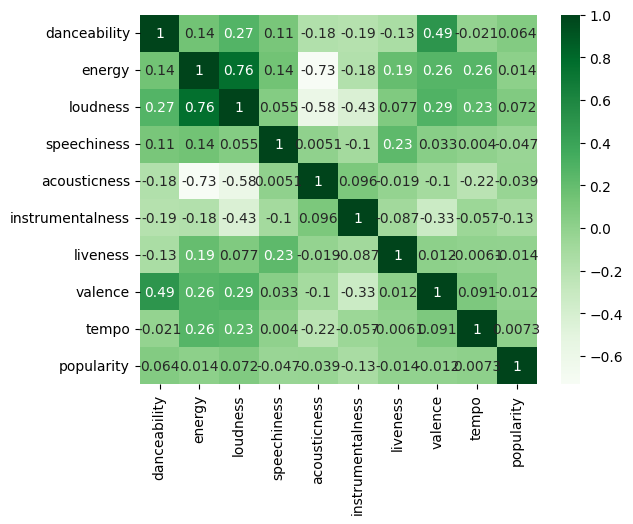

In [16]:
# compute correlation matrix of numerical variables
corr_matrix = df1.corr()

# to plot correlation matrix
sn.heatmap(corr_matrix, cmap="Greens", annot=True)
plt.show()

### Dataset 2: with both and categorical features

In [17]:
# create dataset 2 with both numerical and categorical
df2 = df
print(df2.shape)
dff1 = dff1.set_index("track_id")
df2 = df2.join(dff1,
             on=["track_id"])
print(df2.shape)
# df2 = df2.set_index("track_id")

(89741, 19)
(89741, 133)


We can consider also the other categorical variable as nominal or ordinal


In [18]:
# check unique values of int64 types
print("Feature -> explicit:",df2['explicit'].unique())
print("Feature -> mode:",df2['mode'].unique())
print("Feature -> key:",sorted(df2['key'].unique()))
print("Feature -> time_signature:",sorted(df2['time_signature'].unique()))

Feature -> explicit: [0 1]
Feature -> mode: [0 1]
Feature -> key: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Feature -> time_signature: [0, 1, 3, 4, 5]


In [19]:
# use one hot encoding on key
ohe2 = OneHotEncoder(sparse_output = False,handle_unknown='ignore')
ohe2_out = ohe2.fit_transform(df2[['key']])
# store categories in the list to assign column name
list_key = np.array(ohe2.categories_).tolist()
list_key = list_key[0]
list_key = ["key_" + str(sub) for sub in list_key]
# create dataframe of one-hot encoded columns
ohe2_df = pd.DataFrame(ohe2_out, columns=list_key).astype('Int64')
# merge one-hot encoded columns back with original DataFrame
df2 = df2.reset_index(drop=True)
# df = pd.concat([T1.reset_index(drop=True),T2.reset_index(drop=True)], axis=1)
data_temp = df2.join(ohe2_df)
data_temp

# use one hot encoding on key
ohe3 = OneHotEncoder(sparse_output = False,handle_unknown='ignore')
ohe3_out = ohe3.fit_transform(df2[['time_signature']])
# store categories in the list to assign column name
list_time = np.array(ohe3.categories_).tolist()
list_time = list_time[0]
list_time = ["time_" + str(sub) for sub in list_time]
print(list_time)
# create dataframe of one-hot encoded columns
ohe3_df = pd.DataFrame(ohe3_out, columns=list_time).astype('Int64')

data_temp = data_temp.join(ohe3_df)
data_temp

['time_0', 'time_1', 'time_3', 'time_4', 'time_5']


,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,...,key_7,key_8,key_9,key_10,key_11,time_0,time_1,time_3,time_4,time_5
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,1,-6.746,...,0,0,0,0,0,0,0,0,1,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,1,-17.235,...,0,0,0,0,0,0,0,0,1,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,0,-9.734,...,0,0,0,0,0,0,0,0,1,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,0,-18.515,...,0,0,0,0,0,0,0,1,0,0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,2,-9.681,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,0,0.172,0.2350,5,-16.393,...,0,0,0,0,0,0,0,0,0,1
89737,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,0,0.174,0.1170,0,-18.318,...,0,0,0,0,0,0,0,0,1,0
89738,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,0,0.629,0.3290,0,-10.895,...,0,0,0,0,0,0,0,0,1,0
89739,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,0,0.587,0.5060,7,-10.889,...,1,0,0,0,0,0,0,0,1,0


In [20]:
df2 = data_temp

So the dataset 2 is as following

In [21]:
df2 = df2.set_index("track_id")
df2 = df2.drop(['artists','album_name', 'track_name', 'duration_ms'], axis=1)
df2 = df2.astype('float64')
df2

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_7,key_8,key_9,key_10,key_11,time_0,time_1,time_3,time_4,time_5
track_id,,,,,,,,,,,,,,,,,,,,,
5SuOikwiRyPMVoIQDJUgSV,0.0,0.676,0.4610,1.0,-6.746,0.0,0.1430,0.0322,0.000001,0.3580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4qPNDBW1i3p13qLCt0Ki3A,0.0,0.420,0.1660,1.0,-17.235,1.0,0.0763,0.9240,0.000006,0.1010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1iJBSr7s7jYXzM8EGcbK5b,0.0,0.438,0.3590,0.0,-9.734,1.0,0.0557,0.2100,0.000000,0.1170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6lfxq3CG4xtTiEg7opyCyx,0.0,0.266,0.0596,0.0,-18.515,1.0,0.0363,0.9050,0.000071,0.1320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5vjLSffimiIP26QG5WcN2K,0.0,0.618,0.4430,2.0,-9.681,1.0,0.0526,0.4690,0.000000,0.0829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2C3TZjDRiAzdyViavDJ217,0.0,0.172,0.2350,5.0,-16.393,1.0,0.0422,0.6400,0.928000,0.0863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1hIz5L4IB9hN3WRYPOCGPw,0.0,0.174,0.1170,0.0,-18.318,0.0,0.0401,0.9940,0.976000,0.1050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6x8ZfSoqDjuNa5SVP5QjvX,0.0,0.629,0.3290,0.0,-10.895,0.0,0.0420,0.8670,0.000000,0.0839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
# check na rows if present
df2 = df2.dropna()
print(df2.shape)

# set string name for column name
df2.columns = df2.columns.astype(str)

(89741, 145)


### Training and test set

Prepare training and test set

In [23]:
# Create matrix X with all the features in columns
X1 = df1.drop(['popularity'], axis=1)
X2 = df2.drop(['popularity'], axis=1)
print("Dataset 1: Feature matrix has dimension: -> rows:", X1.shape[0]," and columns:", X1.shape[1])
print("Dataset 2: Feature matrix has dimension: -> rows:", X2.shape[0]," and columns:", X2.shape[1])
# Create y array with alle the labels
#y = df['popularity']
y1 = df1['popularity']
y2 = df2['popularity']
print("Target vector has dimension: -> rows:", y1.shape[0])#," and columns:", Y.shape[1])
print("Target vector has dimension: -> rows:", y2.shape[0])#," and columns:", Y.shape[1])

Dataset 1: Feature matrix has dimension: -> rows: 89741  and columns: 9
Dataset 2: Feature matrix has dimension: -> rows: 89741  and columns: 144
Target vector has dimension: -> rows: 89741
Target vector has dimension: -> rows: 89741


In [24]:
# Get train and test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 1/4, random_state = 0 )
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 1/4, random_state = 0 )

In [25]:
# apply standard scaler on X1
standard_scaler = preprocessing.StandardScaler()
X1_train_std = standard_scaler.fit_transform(X1_train)
X1_test_std = standard_scaler.transform(X1_test)

## Ridge regression

### Baselines

Before starting with the analysis we can set the reference and baseline using  Ridge Regression developed with scikit-learn modules

In [26]:
# Comparison using Scikit learn
alpha_fix = 0.5
rreg1 = linear_model.Ridge(alpha=alpha_fix).fit(X1_train, y1_train)
rreg1_std = linear_model.Ridge(alpha=alpha_fix).fit(X1_train_std, y1_train)
rreg2 = linear_model.Ridge(alpha=alpha_fix).fit(X2_train, y2_train)
print('Ridge regression with alpha = ', alpha_fix, '\n')
print("Dataset 1")
print("- Score on training set:", rreg1.score(X1_train, y1_train))
print("- Score on test set:", rreg1.score(X1_test, y1_test))
print("- Coef:",rreg1.coef_)
print("- Intercept:",rreg1.intercept_,"\n")
print("Dataset 1 standardized")
print("- Score on training set:", rreg1_std.score(X1_train_std, y1_train))
print("- Score on test set:", rreg1_std.score(X1_test_std, y1_test))
print("- Coef:",rreg1_std.coef_)
print("- Intercept:",rreg1_std.intercept_,"\n")
print("Dataset 2")
print("- Score on training set:", rreg2.score(X2_train, y2_train))
print("- Score on test set 2:", rreg2.score(X2_test, y2_test))
print("- Coef:",rreg2.coef_)
print("- Intercept:",rreg2.intercept_)

Ridge regression with alpha =  0.5 

Dataset 1
- Score on training set: 0.029932121474086526
- Score on test set: 0.031675858668009926
- Coef: [ 1.02877368e+01 -2.27625607e+00  8.22731489e-02 -1.23105739e+01
 -1.45399201e+00 -8.89928852e+00  4.86170055e-01 -8.07430613e+00
  6.24297609e-03]
- Intercept: 35.53841913651121 

Dataset 1 standardized
- Score on training set: 0.029932125128053988
- Score on test set: 0.031675369943809706
- Coef: [ 1.8228137  -0.58325385  0.42985148 -1.39936413 -0.49180254 -2.88999154
  0.09501112 -2.12253176  0.188237  ]
- Intercept: 33.15290097318179 

Dataset 2
- Score on training set: 0.29700499299608785
- Score on test set 2: 0.29536129181992143
- Coef: [ 1.36176437e+00  3.71065775e+00 -1.91952840e+00  2.84348676e-03
  4.29012188e-02 -5.92994162e-01 -6.58614710e+00 -9.27082830e-01
 -1.55900679e+00 -1.30959669e+00 -4.83111843e+00  9.10034295e-03
 -2.80629673e-01  6.61489302e+00 -1.13846092e+01  1.15618589e+01
 -1.41900314e+01  9.65256087e+00  1.12626244e+0

### Ridge Reg. from scratch

In [27]:
# function to perform ridge regression
def ridge_regression(X, y, regu):
  # add first column for intercept in the S matrix
  S = np.concatenate([np.ones((len(X), 1)), X], axis=1)
  # Apply ridge regression formula (alpha*I+S.T S)^-1 S.T y
  w_s = (np.linalg.inv(regu*np.identity(S.shape[1])+S.T@S)@S.T)@y
  return w_s

# function to calculate metrics
def calculate_metrics(y_pred,y):
  # calculate Root Mean Squared Errore
  rmse = math.sqrt(((y - y_pred)**2).mean())
  # calculate R^2
  u = ((y - y_pred)** 2).sum()
  y = ((y - y.mean()) ** 2).sum()
  R_squared = 1 - u/y
  return rmse, R_squared

# function to make predictions
def predict(XX, beta):
  # get the prediction given the coefficients
  XX = np.concatenate([np.ones((len(XX), 1)), XX], axis=1)
  y_pred = XX @ beta
  return y_pred

On Dataset 1 std

In [28]:
# Print dimensions
print('Dataset 1 shape>',X1_train_std.shape)
print('Training set dimensions:',X1_train_std.shape)
print('Test set dimensions:',X1_test_std.shape,"\n")

# Ridge Regression with lambda = x
w_1 = ridge_regression(X1_train_std,y1_train,alpha_fix)
print('My ridge regression - Training set')
print('intercept:',w_1[0])
print('coefficients:',w_1[1:],"\n")

# check performance on the training set
y1_train_pred = predict(X1_train_std,w_1)
# calculate metrics
met_train = calculate_metrics(y1_train_pred,y1_train)
print('My ridge regression - Training set')
print('R^2:',met_train[1])
print('Rmse:',met_train[0],"\n")

# check performance on the testing set
y1_test_pred = predict(X1_test_std,w_1)
# calculate metrics
met_test = calculate_metrics(y1_test_pred,y1_test)
print('My ridge regression - Test set')
print('R^2:',met_test[1])
print('Rmse:',met_test[0])

Dataset 1 shape> (67305, 9)
Training set dimensions: (67305, 9)
Test set dimensions: (22436, 9) 

My ridge regression - Training set
intercept: 33.152654686466924
coefficients: [ 1.8228137  -0.58325385  0.42985148 -1.39936413 -0.49180254 -2.88999154
  0.09501112 -2.12253176  0.188237  ] 

My ridge regression - Training set
R^2: 0.029932124983915176
Rmse: 20.204659104722918 

My ridge regression - Test set
R^2: 0.03167519439918176
Rmse: 20.419252600912763


On dataset 2

In [29]:
# Print dimensions
print('Dataset 2',X2_train.shape)
print('Training set dimensions',X2_train.shape)
print('Test set dimensions',X2_test.shape,"\n")

# Ridge Regression with lambda = x
w_2 = ridge_regression(X2_train,y2_train,alpha_fix)
print('My ridge regression - Training set')
print('intercept:',w_2[0])
print('coefficients:',w_2[1:])
# print('R^2:',w_2[2])
# print('Rmse:',w_2[1],"\n")
# calculate metrics
y2_train_pred = predict(X2_train,w_2)
met_train2 = calculate_metrics(y2_train_pred,y2_train)
print('My ridge regression - Training set')
print('R^2:',met_train2[1])
print('Rmse:',met_train2[0],'\n')

# check prediction on test set
y2_test_pred = predict(X2_test,w_2)
# calculate metrics
met_test2 = calculate_metrics(y2_test_pred,y2_test)
print('My ridge regression - Test set')
print('R^2:',met_test2[1])
print('Rmse:',met_test2[0])

Dataset 2 (67305, 144)
Training set dimensions (67305, 144)
Test set dimensions (22436, 144) 

My ridge regression - Training set
intercept: 20.768920512126492
coefficients: [ 1.36188899e+00  3.71590125e+00 -1.91177708e+00  7.96180280e-01
  4.25802714e-02 -5.92375313e-01 -6.58823673e+00 -9.24632400e-01
 -1.55954634e+00 -1.30852708e+00 -4.83182397e+00  9.11527378e-03
  2.69433317e+00  6.61627953e+00 -1.13842444e+01  1.15628616e+01
 -1.41888358e+01  9.65379493e+00  1.12636469e+01 -1.44181599e+01
 -9.62757679e+00  4.19043354e+00  1.00510925e+01 -1.69077299e+01
  8.21202676e+00 -3.70556875e+00 -2.41320553e+01 -5.27368187e-01
  1.91941003e+01 -2.02798566e+01 -3.32627843e+00 -6.35431023e+00
 -1.97716513e+01 -1.42383211e+01  1.64941959e+00 -5.84552259e+00
  9.04217919e+00 -2.52924296e+01  3.09653866e+00 -8.74961802e+00
 -9.87837141e+00 -4.19068042e+00  2.03956234e+00  1.36379415e+01
 -6.08627471e+00  7.22226314e+00  1.25190936e+01  4.15513708e+00
  5.95136289e+00  4.29136937e+00  9.35862371e+

### Cross Validation

Using standard available methods

In [30]:
# with standard methods applicable on scikit-learn predictors
scores = cross_val_score(rreg2, X2_train, y2_train, cv=5)
print("ridge scikit-learn",scores, scores.mean())

ridge scikit-learn [0.30096161 0.28706436 0.2944375  0.28887606 0.29856597] 0.29398109980302783


Hybrid solution:
- using KFold methods from scikit-learn
- applied on Ridge Regression from scratch

In [31]:
def K_fold_cv_ridge(kf_split,X,y,alpha,n_split):
  # function to perform cross validation on ridge regression
  # starting from splits obtained with K fold partitioning
  # create score matrix to store metrics ()
  score_cv_tr = np.zeros((n_split,2))
  score_cv_ts = np.zeros((n_split,2))
  i = 0
  # perform Cross Validation on K_fold splitted indexes
  for train_index, test_index in kf_split:
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv = X.iloc[train_index]
    X_test_cv = X.iloc[test_index]
    y_train_cv = y[train_index]
    y_test_cv = y[test_index]
    # perform ridge regression on the K-fold training set
    ww_cv =ridge_regression(X_train_cv, y_train_cv, alpha)
    # get the prediction on the training set and testing set
    y_train_pred = predict(X_train_cv,ww_cv)
    y_test_pred = predict(X_test_cv,ww_cv)
    # # calculate metrics of training and testing error
    met_train_cv = calculate_metrics(y_train_pred,y_train_cv)
    met_test_cv = calculate_metrics(y_test_pred,y_test_cv)
    # save the result of the metrics
    score_cv_tr[i,:] = met_train_cv
    score_cv_ts[i,:] = met_test_cv
    i +=1
  # return score_cv
  return score_cv_tr, score_cv_ts

In [32]:
# number of split and K-FOLD
n_s = 5

# use KFold from scikit-learn
kf = KFold(n_splits=n_s)
Xk = kf.split(X2_train)

# Compute CV result
score2_cv_tr,score2_cv_ts = K_fold_cv_ridge(Xk,X2_train,y2_train,alpha_fix,n_s)
print(score2_cv_ts)
np.mean(score2_cv_ts,axis=0)

[[17.2751963   0.30096157]
 [17.26824656  0.28706555]
 [17.20904207  0.29443627]
 [17.19263541  0.28887585]
 [17.23614165  0.29856607]]


array([17.2362524 ,  0.29398106])

Cross validation using:
- Kfold split done from scratch
- ridge regression from scratch

In [33]:
def create_splits(X,n_splits):
  # function that perform n_splits of the indexes given in X
  # check the number of splits and samples
  n_samples = X.shape[0]
  if n_splits > n_samples:
    sys.exit("Number of splits cannot be higher than number of samples")
  # set up
  fold_size = n_samples//n_splits # size of fold, used floor divison
  k_index = np.arange(n_samples) #assign an index to the samples
  fold_train =[]
  fold_test = []
  fold = []
  # for loop to create splits
  for j in range(n_splits):
    test_indices = k_index[j*fold_size:(j+1)*(fold_size)] #index of test set
    train_indices_pre = k_index[:j*fold_size] # indices pre test indices
    train_indices_post = k_index[(j+1)*(fold_size):] # indices post test indices
    train_indices = np.concatenate((train_indices_pre, train_indices_post)) # concatenate
    # store training and test indices
    fold_train.append(train_indices)
    fold_test.append(test_indices)
    fold.append((train_indices,test_indices)) # fold indices
  return fold

In [34]:
# using KFold from scratch
Xk = create_splits(X2_train,n_s)
print("Indices obtained with KFold from scratch:\n")
for i in range(n_s):
  print(Xk[i])
print("\n")

# compute score
score2_cv_tr,score2_cv_ts = K_fold_cv_ridge(Xk,X2_train,y2_train,alpha_fix,n_s)
print("Scores - testing:\n",score2_cv_ts)
print("CV score",np.mean(score2_cv_ts,axis=0))

Indices obtained with KFold from scratch:

(array([13461, 13462, 13463, ..., 67302, 67303, 67304]), array([    0,     1,     2, ..., 13458, 13459, 13460]))
(array([    0,     1,     2, ..., 67302, 67303, 67304]), array([13461, 13462, 13463, ..., 26919, 26920, 26921]))
(array([    0,     1,     2, ..., 67302, 67303, 67304]), array([26922, 26923, 26924, ..., 40380, 40381, 40382]))
(array([    0,     1,     2, ..., 67302, 67303, 67304]), array([40383, 40384, 40385, ..., 53841, 53842, 53843]))
(array([    0,     1,     2, ..., 53841, 53842, 53843]), array([53844, 53845, 53846, ..., 67302, 67303, 67304]))


Scores - testing:
 [[17.2751963   0.30096157]
 [17.26824656  0.28706555]
 [17.20904207  0.29443627]
 [17.19263541  0.28887585]
 [17.23614165  0.29856607]]
CV score [17.2362524   0.29398106]


### Hyper param tuning

In [35]:
# parameter of alpha
n_alphas = 50
alphas = np.logspace(-2, 7, n_alphas) # spaced evenly on a logspace
# print(alphas)

Intuition about the parameters variability shrinking towards 0 as alpha gets big

In [36]:
# get coefficient variability depending on alpha
coefs1 = []
coefs2 = []
for a in alphas:
  w_rr1 = ridge_regression(X1_train_std,y1_train,a) #ridge regression
  coefs1.append(list(w_rr1[1:]))
  w_rr2 = ridge_regression(X2_train,y2_train,a) #ridge regression
  coefs2.append(list(w_rr2[1:]))

(0.0035481338923357532,
 28183829.31264455,
 -35.885379579387056,
 25.726367964796424)

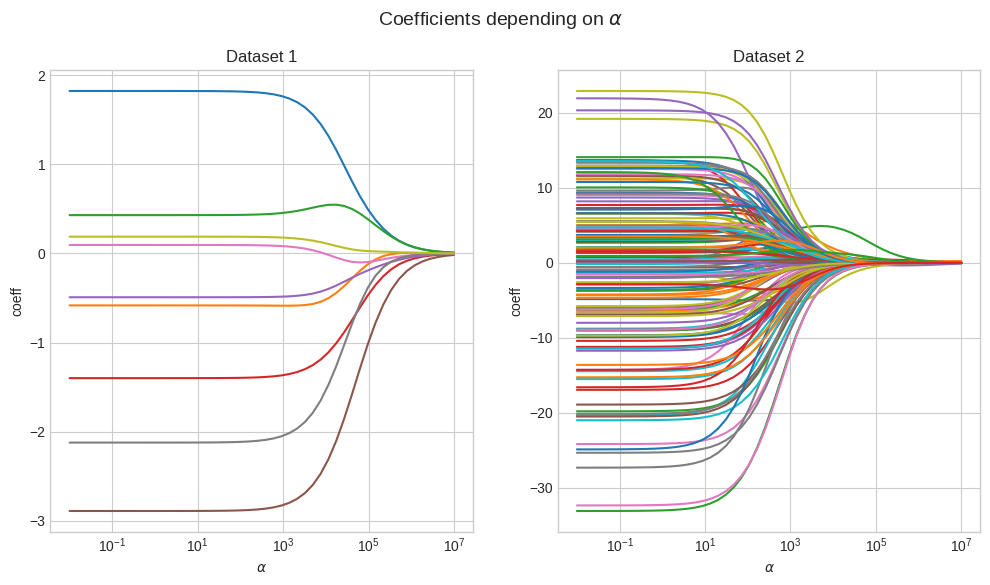

In [37]:
# Plot Ridge regression coefficients dependence on alpha

# setting style
# plt.style.use('default')
# plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 6))
plt.suptitle('Coefficients depending on 'r'$\alpha$', fontsize=14)

# dataset 1
ax1.plot(alphas, coefs1)
ax1.set_xscale("log")
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel("coeff")
ax1.set_title("Dataset 1")
ax1.axis("tight")

# dataset 2
ax2.plot(alphas, coefs2)
ax2.set_xscale("log")
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel("coeff")
ax2.set_title("Dataset 2")
ax2.axis("tight")

Dataset 1

In [38]:
# Using standard methords from scikit/-learn
grid_mod1 = GridSearchCV(
    linear_model.Ridge(),
    param_grid={"alpha": alphas},
)
grid_mod1.fit(X1_train, y1_train)
print(f"Best Ridge Regression with params: {grid_mod1.best_params_}and R2 score: {grid_mod1.best_score_:.4f}")

Best Ridge Regression with params: {'alpha': 3.7275937203149416}and R2 score: 0.0297


In [39]:
# create splits from previous method of CV
Xk1 = create_splits(X1_train,n_s)
# lists to store scores with different hyper parameters
m_cv_hyp1_tr = np.zeros((n_alphas,2))
m_cv_hyp1_ts = np.zeros((n_alphas,2))
i=0
for a in alphas:
  # dataset 1 with a = alpha[i] and cv = 5
  score1_cv_hyp_tr,score1_cv_hyp_ts = K_fold_cv_ridge(Xk1,X1_train,y1_train,a,n_s)
  m_cv_hyp1_tr[i,:] = np.mean(score1_cv_hyp_tr,axis=0) #training scores
  m_cv_hyp1_ts[i,:] = np.mean(score1_cv_hyp_ts,axis=0) #testing scores
  i+=1

In [40]:
def plot_TrainTest_scores(train_score_RMSE,test_score_RMSE,train_score_R2,test_score_R2,alphas,title_str,x_var):
  # Setting plot style
  plt.style.use('default')
  # plt.style.use('ggplot')
  # plt.style.use('seaborn-v0_8-whitegrid')

  # Plot KRR training and testing score depending on gamma
  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 6))
  plt.suptitle(title_str, fontsize=14)

  # alpha and coefficients
  ax1.plot(alphas, train_score_RMSE, label='Training RMSE')
  ax1.plot(alphas, test_score_RMSE, label='Testing RMSE')
  ax1.set_xscale("log")
  ax1.set_xlabel(x_var)
  ax1.set_ylabel("RMSE")
  ax1.set_title("RMSE trend")
  ax1.axis("tight")
  ax1.legend(loc="upper left")

  # alpha and RMSE
  ax2.plot(alphas, train_score_R2, label='Training R2')
  ax2.plot(alphas, test_score_R2, label='Testing R2')
  ax2.set_xscale("log")
  ax2.set_xlabel(x_var)
  ax2.set_ylabel("R2")
  ax2.set_title("R2 trend")
  ax2.axis("tight")
  ax2.legend(loc="lower left")
  plt.show()

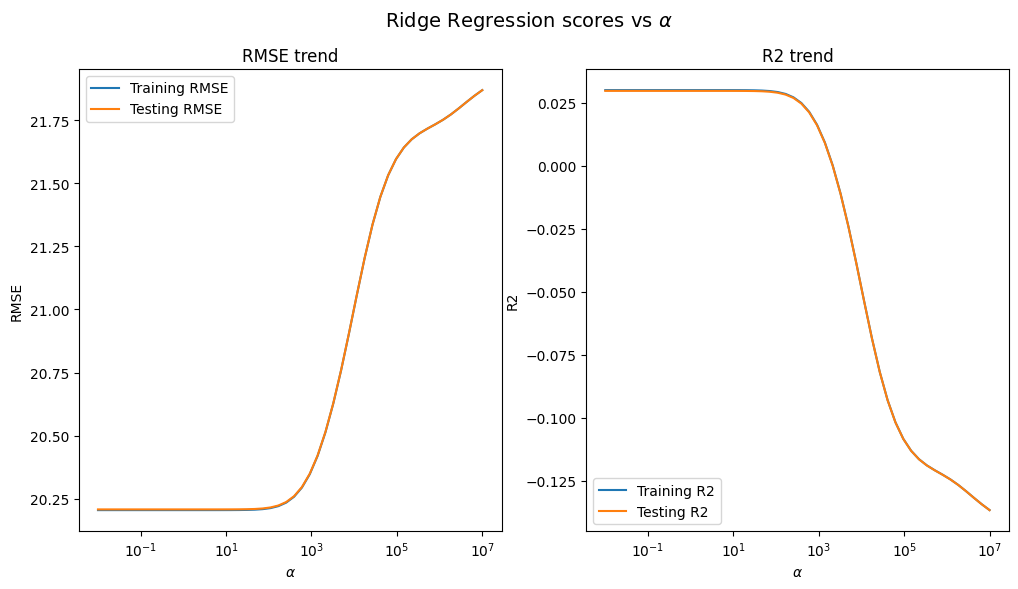

In [41]:
# plot train and testing error
title_txt = 'Ridge Regression scores vs 'r'$\alpha$'
varx = r'$\alpha$'
plot_TrainTest_scores(m_cv_hyp1_tr[:,0],m_cv_hyp1_ts[:,0],m_cv_hyp1_tr[:,1],m_cv_hyp1_ts[:,1],alphas,title_txt,varx)

In [42]:
# to print best values of R^2 and alpha
rmse1_lst = m_cv_hyp1_ts[:,0]
r1_lst = m_cv_hyp1_ts[:,1]
rmse1_lst = rmse1_lst.tolist() # convert to list
r1_lst = r1_lst.tolist() # convert to list
id_best1 = r1_lst.index(max(r1_lst)) # find best index when max value of R^2
a1_best = alphas[id_best1]
print('best alpha:',a1_best,'\nwith R^2 max:',m_cv_hyp1_ts[id_best1,1], "\nand RMSE min:",m_cv_hyp1_ts[id_best1,0])

best alpha: 1.0481131341546863 
with R^2 max: 0.02966848053216444 
and RMSE min: 20.207172834573196


In [43]:
# comparison with grid search
id_best_grid1 = id_best1+3 # offset
print('best alpha:',alphas[id_best_grid1],'\nwith R^2 max:',m_cv_hyp1_ts[id_best_grid1,1], "\nand RMSE min:",m_cv_hyp1_ts[id_best_grid1,0])

best alpha: 3.7275937203149416 
with R^2 max: 0.02966793941678323 
and RMSE min: 20.207178309699458


Dataset 2

In [44]:
# Using standard methords from scikit-learn
grid_mod2 = GridSearchCV(
    linear_model.Ridge(),
    param_grid={"alpha": alphas},
)
grid_mod2.fit(X2_train, y2_train)
print(f"Best Ridge Regression with params: {grid_mod2.best_params_}and R2 score: {grid_mod2.best_score_:.4f}")

Best Ridge Regression with params: {'alpha': 2.442053094548652}and R2 score: 0.2940


In [45]:
# lists to store data of hyper parameter tuning
m_cv_hyp2_tr = np.zeros((n_alphas,2))
m_cv_hyp2_ts = np.zeros((n_alphas,2))
i=0
for a in alphas:
  # dataset 2 with a = alpha[i] and cv = 5
  score2_cv_hyp_tr,score2_cv_hyp_ts = K_fold_cv_ridge(Xk,X2_train,y2_train,a,n_s)
  m_cv_hyp2_tr[i,:] = np.mean(score2_cv_hyp_tr,axis=0) # training scores
  m_cv_hyp2_ts[i,:] = np.mean(score2_cv_hyp_ts,axis=0) # testing scores
  i+=1

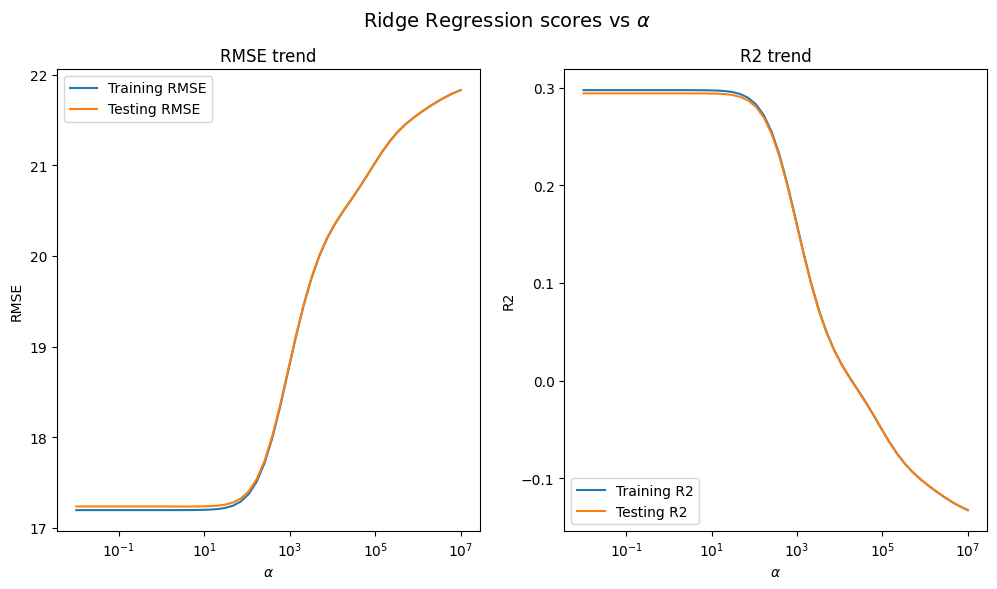

In [46]:
# plot train and testing error
title_2 = 'Ridge Regression scores vs 'r'$\alpha$'
varx_2 = r'$\alpha$'
plot_TrainTest_scores(m_cv_hyp2_tr[:,0],m_cv_hyp2_ts[:,0],m_cv_hyp2_tr[:,1],m_cv_hyp2_ts[:,1],alphas,title_2,varx_2)

In [47]:
# to print best values of R^2 and alpha
rmse2_lst = m_cv_hyp2_ts[:,0]
r2_lst = m_cv_hyp2_ts[:,1]
rmse2_lst = rmse2_lst.tolist() # convert to list
r2_lst = r2_lst.tolist() # convert to list
id_best2 = r2_lst.index(max(r2_lst)) # find best index when max value of R^2
a2_best = alphas[id_best2]
print('best alpha:',a2_best,'\nwith R^2 max:',m_cv_hyp2_ts[id_best2,1], "\nand RMSE min:",m_cv_hyp2_ts[id_best2,0])

best alpha: 2.442053094548652 
with R^2 max: 0.29399138151429416 
and RMSE min: 17.236131751177343


In [48]:
# comparison with grid search
id_best_grid2 = id_best2+1
print('best alpha:',alphas[id_best_grid2],'\nwith R^2 max:',m_cv_hyp2_ts[id_best_grid2,1], "\nand RMSE min:",m_cv_hyp2_ts[id_best_grid2,0])

best alpha: 3.7275937203149416 
with R^2 max: 0.2939863614724875 
and RMSE min: 17.236196460050074


In [49]:
# Use alpha_best in Ridge Regression and evaluate it testing set
w_best_2 = ridge_regression(X2_train,y2_train,a2_best)
# check prediction on test set
y2_test_pred = predict(X2_test,w_best_2)
# calculate metrics
met_test2 = calculate_metrics(y2_test_pred,y2_test)
print('My ridge regression - Test set')
print('R^2:',met_test2[1])
print('Rmse:',met_test2[0])

My ridge regression - Test set
R^2: 0.29533546366323016
Rmse: 17.418891768273234


Check what happens using CV on the full dataset

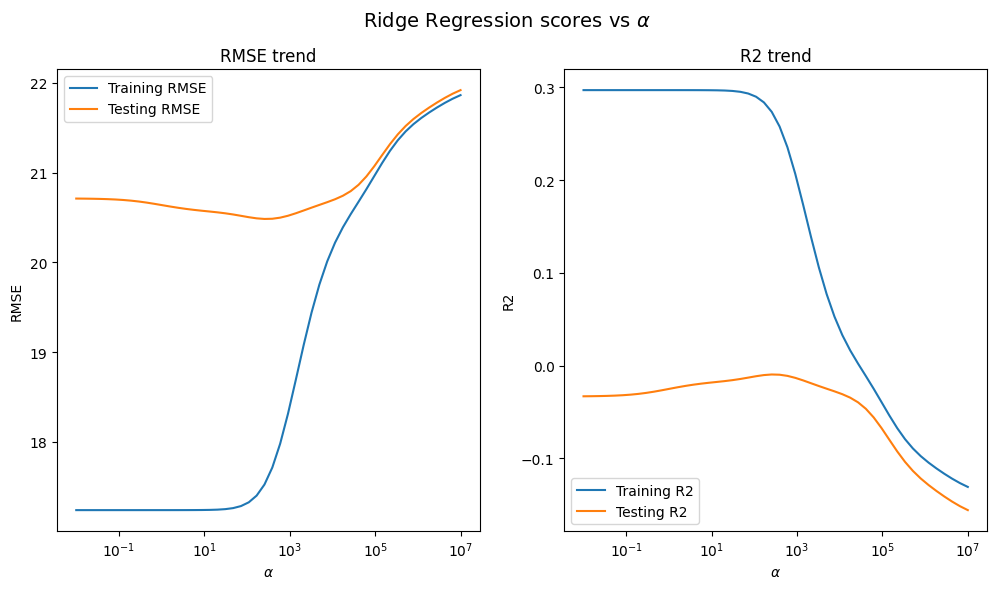

In [50]:
# create splits from previous method of CV
Xkk = create_splits(X2,n_s)
# lists to store data of hyper parameter tuning
m_cv_hyp2f_tr = np.zeros((n_alphas,2))
m_cv_hyp2f_ts = np.zeros((n_alphas,2))
i=0
for a in alphas:
  # dataset 2 with a = alpha[i] and cv = 5
  score2f_cv_hyp_tr,score2f_cv_hyp_ts = K_fold_cv_ridge(Xkk,X2,y2,a,n_s)
  m_cv_hyp2f_tr[i,:] = np.mean(score2f_cv_hyp_tr,axis=0) # training scores
  m_cv_hyp2f_ts[i,:] = np.mean(score2f_cv_hyp_ts,axis=0) # testing scores
  i+=1
# plot train and testing error
title_2 = 'Ridge Regression scores vs 'r'$\alpha$'
varx_2 = r'$\alpha$'
plot_TrainTest_scores(m_cv_hyp2f_tr[:,0],m_cv_hyp2f_ts[:,0],m_cv_hyp2f_tr[:,1],m_cv_hyp2f_ts[:,1],alphas,title_2,varx_2)

### Model Performances

## Kernel Ridge Regression

Due to memory issues dataset should be shortened

### Memory & set shrinkage
Memory analysis about matrices storage space


In [51]:
size_float32 = 8 #bytes # (32 bits or 4 bytes)
train_size_mem = 20000
total = size_float32 *train_size_mem**2
print(total/1e09)

3.2


In [52]:
# parameters setting
alpha_fix = 0.5
gamma_fix = 1

# consider a simpler dataset
train_size = 3000
X1K_train, y1K_train = X1_train_std[:train_size], y1_train[:train_size]
X1K_test, y1K_test = X1_train_std[train_size :train_size+round(train_size*0.2)], y1_train[train_size :train_size+round(train_size*0.2)]

X2K_train, y2K_train = X2_train[:train_size], y2_train[:train_size]
X2K_test, y2K_test = X2_train[train_size :train_size+round(train_size*0.2)], y2_train[train_size :train_size+round(train_size*0.2)]

# Show reduced dimensions
print('training set:',X1K_train.shape)
print('test set:',X1K_test.shape)

training set: (3000, 9)
test set: (600, 9)


### Baseline

Using tools from sklearn as comparison

In [53]:
print("Comparison with scikit learn KernelRidge\n")

def baseline_recap(X_tr,y_tr,X_ts,y_ts):
  # use scikit-learn and calculate computational time
  t0 = time.time() # start time
  regK = KernelRidge(kernel='rbf', gamma=gamma_fix, alpha=alpha_fix)
  regK.fit(X_tr,y_tr)
  t_KK_scikit = time.time() - t0 #end time
  print('Time:  %.3f' % t_KK_scikit)

  # compute RMSE and R^2 on Test set
  y_predK = regK.predict(X_ts) # prediction on new values of testing set
  rmseK = math.sqrt(metrics.mean_squared_error(y_ts,y_predK))
  R2K = metrics.r2_score(y2K_test,y_predK)
  print('RMSE on test set: %.3f' % rmseK)
  print('Coef of determination R^2: %.3f \n' % R2K)

  # compute RMSE and R^2 on Training set
  y_predKT = regK.predict(X_tr) # prediction on already seen values of training set
  rmseKT = math.sqrt(metrics.mean_squared_error(y_tr,y_predKT))
  R2KT = metrics.r2_score(y_tr,y_predKT)
  print('RMSE on training set: %.3f' % rmseKT)
  print('Coef of determination R^2: %.3f' % R2KT)

print("\n#### DATASET 1 ####")
baseline_recap(X1K_train,y1K_train,X1K_test,y1K_test)

print("\n#### DATASET 2 ####")
baseline_recap(X2K_train,y2K_train,X2K_test,y2K_test)

Comparison with scikit learn KernelRidge


#### DATASET 1 ####
Time:  0.676
RMSE on test set: 23.097
Coef of determination R^2: -0.213 

RMSE on training set: 12.285
Coef of determination R^2: 0.656

#### DATASET 2 ####
Time:  1.752
RMSE on test set: 37.417
Coef of determination R^2: -2.184 

RMSE on training set: 12.853
Coef of determination R^2: 0.623


### KRR from scratch: solution 1

Due to time consuming solution only very small training set are considered

In [54]:
# set max length of the dataset due to memory issue
part_len = round(train_size)
x_k = X1K_train[0:part_len,:]
K_k = np.zeros((x_k.shape[0],x_k.shape[0]))
print(K_k.shape)

(3000, 3000)


In [55]:
# check number of features for for loops
m = x_k.shape[0]

# check time performances
t0 = time.time()

def gauss_kernel(z1,z2,gamma):
    return np.exp(-gamma*np.linalg.norm(z1-z2)**2)

# kernel trick to build Gaussian Kernel
for i in range(m):
  for j in range(m):
    K_k[i,j] = gauss_kernel(x_k[i,:], x_k[j,:], gamma_fix)
k_k_T = time.time() - t0

# Print computation tile
print("Time to compute K with nested for loops",k_k_T)

Time to compute K with nested for loops 68.64158344268799


### KRR from scratch: solution 2

#### Broadcasting example

In order to speed up the Gaussian kernel we can use broadcasting of Numpy
https://numpy.org/doc/stable/user/basics.broadcasting.html

In [56]:
# Transform training set in numpy array
XX = np.array(X1_train.iloc[:5,:])
print("Initial dimensions of X:",XX.shape)
# add a new dimension
YY = XX[:,np.newaxis]
print("New dimensions of X:",YY.shape)
# consider different XX1
XX1 = np.array(X1_train.iloc[:3,:])
print("Initial dimensions of X':",XX1.shape)
# compute the difference of the matrices
ZZ=XX1-YY
print("Matrix X-X' dimension:",ZZ.shape)
# compute the square of the matrix
ZZ1 = np.sum((ZZ)**2,axis=-1)
print("(X-X')**2  dimension:",ZZ1.shape)
# compute the Gaussian Kernel
k_gauss = np.exp(-gamma_fix*ZZ1)
print("Gaussian Kernel matrix dimension':",k_gauss.shape)

Initial dimensions of X: (5, 9)
New dimensions of X: (5, 1, 9)
Initial dimensions of X': (3, 9)
Matrix X-X' dimension: (5, 3, 9)
(X-X')**2  dimension: (5, 3)
Gaussian Kernel matrix dimension': (5, 3)


Step by step

In [57]:
# Transform training set in numpy array
XX = np.array(X1_train.iloc[:5,:])
print(XX.shape)
XX

(5, 9)


array([[ 4.37000e-01,  8.03000e-01, -4.79100e+00,  4.00000e-02,
         4.46000e-05,  1.64000e-02,  1.07000e-01,  7.35000e-01,
         1.47507e+02],
       [ 4.05000e-01,  9.30000e-01, -5.57300e+00,  7.22000e-02,
         1.87000e-02,  2.16000e-04,  3.56000e-01,  4.32000e-01,
         1.27336e+02],
       [ 8.34000e-01,  3.85000e-01, -1.10500e+01,  4.41000e-01,
         1.93000e-01,  2.31000e-04,  3.44000e-01,  2.89000e-01,
         1.15089e+02],
       [ 5.17000e-01,  8.58000e-01, -5.16800e+00,  1.03000e-01,
         1.32000e-01,  0.00000e+00,  9.20000e-02,  5.50000e-01,
         1.00040e+02],
       [ 7.45000e-01,  3.46000e-01, -1.07640e+01,  3.87000e-02,
         7.39000e-01,  0.00000e+00,  1.30000e-01,  7.10000e-01,
         1.69689e+02]])

In [58]:
# add a new dimension
YY = XX[:,np.newaxis]
print(YY.shape)
YY

(5, 1, 9)


array([[[ 4.37000e-01,  8.03000e-01, -4.79100e+00,  4.00000e-02,
          4.46000e-05,  1.64000e-02,  1.07000e-01,  7.35000e-01,
          1.47507e+02]],

       [[ 4.05000e-01,  9.30000e-01, -5.57300e+00,  7.22000e-02,
          1.87000e-02,  2.16000e-04,  3.56000e-01,  4.32000e-01,
          1.27336e+02]],

       [[ 8.34000e-01,  3.85000e-01, -1.10500e+01,  4.41000e-01,
          1.93000e-01,  2.31000e-04,  3.44000e-01,  2.89000e-01,
          1.15089e+02]],

       [[ 5.17000e-01,  8.58000e-01, -5.16800e+00,  1.03000e-01,
          1.32000e-01,  0.00000e+00,  9.20000e-02,  5.50000e-01,
          1.00040e+02]],

       [[ 7.45000e-01,  3.46000e-01, -1.07640e+01,  3.87000e-02,
          7.39000e-01,  0.00000e+00,  1.30000e-01,  7.10000e-01,
          1.69689e+02]]])

In [59]:
# compute the difference in order to
ZZ=XX-YY
print(ZZ.shape)
ZZ

(5, 5, 9)


array([[[ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
          0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
          0.000000e+00],
        [-3.200000e-02,  1.270000e-01, -7.820000e-01,  3.220000e-02,
          1.865540e-02, -1.618400e-02,  2.490000e-01, -3.030000e-01,
         -2.017100e+01],
        [ 3.970000e-01, -4.180000e-01, -6.259000e+00,  4.010000e-01,
          1.929554e-01, -1.616900e-02,  2.370000e-01, -4.460000e-01,
         -3.241800e+01],
        [ 8.000000e-02,  5.500000e-02, -3.770000e-01,  6.300000e-02,
          1.319554e-01, -1.640000e-02, -1.500000e-02, -1.850000e-01,
         -4.746700e+01],
        [ 3.080000e-01, -4.570000e-01, -5.973000e+00, -1.300000e-03,
          7.389554e-01, -1.640000e-02,  2.300000e-02, -2.500000e-02,
          2.218200e+01]],

       [[ 3.200000e-02, -1.270000e-01,  7.820000e-01, -3.220000e-02,
         -1.865540e-02,  1.618400e-02, -2.490000e-01,  3.030000e-01,
          2.017100e+01],
        [ 0.000000e+

In [60]:
# square the difference and get the rounded mxm kernalized matrix
ZZ1 = np.sum((ZZ)**2,axis=-1)
print(ZZ1.shape)
ZZ1.round(4)

(5, 5)


array([[   0.    ,  407.6534, 1090.8875, 2253.3237,  528.569 ],
       [ 407.6534,    0.    ,  180.6546,  745.3508, 1821.8281],
       [1090.8875,  180.6546,    0.    ,  261.6441, 2981.9342],
       [2253.3237,  745.3508,  261.6441,    0.    , 4883.0122],
       [ 528.569 , 1821.8281, 2981.9342, 4883.0122,    0.    ]])

In [61]:
# apply gaussian formula
k_gauss = np.exp(-gamma_fix*ZZ1)
k_gauss#.round(2)

array([[1.00000000e+000, 9.08633619e-178, 0.00000000e+000,
        0.00000000e+000, 2.78856090e-230],
       [9.08633619e-178, 1.00000000e+000, 3.48905671e-079,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 3.48905671e-079, 1.00000000e+000,
        2.34097509e-114, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 2.34097509e-114,
        1.00000000e+000, 0.00000000e+000],
       [2.78856090e-230, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000]])

Check correctness of implemented Gaussian kernel

We can start considering already available function to build kernalized matrices to compare the output

In [62]:
# compare with standard calculation
k_gskit = metrics.pairwise.rbf_kernel(XX,gamma=gamma_fix)
print(k_gskit.shape)
k_gskit.round(2)

(5, 5)


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [63]:
# Check error difference
k1 = k_gskit - k_gauss
print(np.sum(k1)) #errori is neglictable
k1.round(10)


-1.844505576927051e-90


array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0.],
       [ 0., -0.,  0., -0.,  0.],
       [ 0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

#### Implementation of kernel ridge regression

In [64]:
# check types and in pandas dataframes need to be transformed into numpy arrays
print(type(X1K_train))
print(type(X1_train_std))

print(type(X2K_train))
print(type(X2_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [65]:
def KernelRidgeReg(X_tr,y_tr,X_ts,y_ts,gamma,alpha, print_out=True):
  # Kernel ridge regression function
  # X_tr: training dataset | y_tr: training values --> (simplified X  and Y)
  # X_ts: testing dataset |y_ts: testing values --> (simplified x and y)
  # the Ridge Regression predictor in RHKS is given
  # y = Y'(alpha*I+K(X,X))^{-1}*k(x,X)

  # compute the Gaussian kernel matrix --> K(X,X)
  t0 = time.time() # start time
  k_gauss = np.exp(-gamma*np.sum((X_tr - X_tr[:,np.newaxis])**2,axis=-1))

  # compute the coefficients --> w = Y'(alpha*I+K(X,X))^{-1}
  KinvAlpha = np.linalg.inv(alpha*np.eye(X_tr.shape[0])+k_gauss)
  w_kern = y_tr.T @ KinvAlpha
  KK_new_T = time.time() - t0 # end time

  # ON TRAINING SET
  k_gauss_train = k_gauss # kernel matrix --> k() = k(x,X)
  y_pred_train = k_gauss_train @ w_kern # predictor --> y_pred = w * K(x, X')
  score_train = calculate_metrics(y_pred_train,y_tr) # get the score

  # ON TEST SET
  k_gauss2 = np.exp(-gamma*np.sum((X_ts - X_tr[:,np.newaxis])**2,axis=-1))
  y_pred_test = np.dot(k_gauss2.T,w_kern) #y_pred = w * K(x, X')
  score_test = calculate_metrics(y_pred_test,y_ts)

  # print output if label is empty or True
  if print_out == True:
    print('Time to K Gaussian with broadcasting: %.3f' % KK_new_T) #time
    print("Shape of kernel matrix:",k_gauss.shape) #check dimension
    print('Training result')
    print('R^2:',f"{score_train[1]:.3f}",' | Rmse:',f"{score_train[0]:.3f}")
    print('Testing result')
    print('R^2:',f"{score_test[1]:.3f}",' | Rmse:',f"{score_test[0]:.3f}")

  return score_train, score_test

In [66]:
# Dataset 1
sc1_train, sc1_test = KernelRidgeReg(X1K_train, y1K_train,X1K_test, y1K_test,gamma_fix,alpha_fix)

Time to K Gaussian with broadcasting: 3.020
Shape of kernel matrix: (3000, 3000)
Training result
R^2: 0.656  | Rmse: 12.285
Testing result
R^2: -0.213  | Rmse: 23.097


In [67]:
# Dataset 2
sc2_train, sc2_test =KernelRidgeReg(np.array(X2K_train), np.array(y2K_train), np.array(X2K_test), np.array(y2K_test), gamma_fix,alpha_fix)

Time to K Gaussian with broadcasting: 15.871
Shape of kernel matrix: (3000, 3000)
Training result
R^2: 0.623  | Rmse: 12.853
Testing result
R^2: -2.184  | Rmse: 37.417


### Cross validation

changing previous function of CV

In [68]:
def K_fold_cv_KRR(kf_split,X,y,gamma, alpha,n_split):
  # function to perform cross validation on kernel ridge regression
  # starting from splits obtained with K fold partitioning

  # create score matrix to store metrics ()
  score_cv_tr = np.zeros((n_split,2))
  score_cv_ts = np.zeros((n_split,2))
  i = 0
  # perform Cross Validation on K_fold splitted indexes
  for train_index, test_index in kf_split:
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv = X[train_index]
    X_test_cv = X[test_index]
    y_train_cv = y[train_index]
    y_test_cv = y[test_index]
    # perform kernel ridge regression on the K-fold training set
    sc2_train, sc2_test = KernelRidgeReg(X_train_cv, y_train_cv,X_test_cv, y_test_cv,gamma,alpha,False)
    score_cv_tr[i,:]=sc2_train
    score_cv_ts[i,:]=sc2_test
    i +=1
  # return score_cv_ts
  return score_cv_tr, score_cv_ts

# number of split and K-FOLD
n_s = 5

# use KFold from scratch
Xk = create_splits(X1K_train,n_s)

# compute score
score1_cv_tr, score1_cv_ts = K_fold_cv_KRR(Xk,X1K_train,y1K_train,gamma_fix,alpha_fix,n_s)
print("Scores obtained:\n",score1_cv_ts)
print("CV score",np.mean(score1_cv_ts,axis=0))

Scores obtained:
 [[24.81969467 -0.35579441]
 [24.5988242  -0.39368758]
 [24.50493616 -0.3415236 ]
 [23.96125022 -0.38855307]
 [24.01509006 -0.30826582]]
CV score [24.37995906 -0.3575649 ]


In [69]:
# with standard methods applicable on scikit-learn predictors
regK = KernelRidge(kernel='rbf', gamma=gamma_fix, alpha=alpha_fix)
scores = cross_val_score(regK, X1K_train,y1K_train, cv=5)
print("kernel ridge scikit-learn",scores, scores.mean())

kernel ridge scikit-learn [-0.35579441 -0.39368758 -0.3415236  -0.38855307 -0.30826582] -0.3575648966894839


### Hyper parameters tuning and Model Perforamnces

In [70]:
# parameter of alpha
n_alphas = 5
alphas = np.logspace(-2, 4, n_alphas) # spaced evenly on a logspace

# parameter of gaamma
n_gammas = 5
gammas = np.logspace(-3, 2, n_gammas) # spaced evenly on a logspace

print(alphas)
print(gammas)

[1.00000000e-02 3.16227766e-01 1.00000000e+01 3.16227766e+02
 1.00000000e+04]
[1.00000000e-03 1.77827941e-02 3.16227766e-01 5.62341325e+00
 1.00000000e+02]


In [71]:
# Using standard methords
kr = GridSearchCV(
    KernelRidge(kernel="rbf"),
    param_grid={"alpha": alphas, "gamma": gammas},
)

t0 = time.time()
kr.fit(X1K_train, y1K_train)
kr_fit = time.time() - t0
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR GridSearchCV time: %.3f s" % kr_fit)

Best KRR with params: {'alpha': 0.31622776601683794, 'gamma': 0.01778279410038923} and R2 score: 0.057
KRR GridSearchCV time: 120.407 s


In [72]:
# hyper param from scratch

# settings
score_RMSE_tr = np.zeros((n_gammas,n_alphas))
score_R2_tr = np.zeros((n_gammas,n_alphas))
score_RMSE_ts = np.zeros((n_gammas,n_alphas))
score_R2_ts = np.zeros((n_gammas,n_alphas))
ii= 0
jj = 0

t0s = time.time() #start time
# for loop for hyp param search
for g in gammas:
  for a in alphas:
    print("gamma:", f"{g:.4f}", "alpha:",f"{a:.4f}")
    score_krr_tr, score_krr_ts = K_fold_cv_KRR(Xk,X1K_train,y1K_train,g,a,n_s)
    score_RMSE_tr[ii,jj] = np.mean(score_krr_tr[:,0],axis=0)
    score_R2_tr[ii,jj] = np.mean(score_krr_tr[:,1],axis=0)
    score_RMSE_ts[ii,jj] = np.mean(score_krr_ts[:,0],axis=0)
    score_R2_ts[ii,jj] = np.mean(score_krr_ts[:,1],axis=0)
    jj+=1
  ii+=1
  jj=0 #to reset index column

t_krSearch = time.time() - t0s
print("Hyp-param tuning time: %.3f s" % t_krSearch)

gamma: 0.0010 alpha: 0.0100
gamma: 0.0010 alpha: 0.3162
gamma: 0.0010 alpha: 10.0000
gamma: 0.0010 alpha: 316.2278
gamma: 0.0010 alpha: 10000.0000
gamma: 0.0178 alpha: 0.0100
gamma: 0.0178 alpha: 0.3162
gamma: 0.0178 alpha: 10.0000
gamma: 0.0178 alpha: 316.2278
gamma: 0.0178 alpha: 10000.0000
gamma: 0.3162 alpha: 0.0100
gamma: 0.3162 alpha: 0.3162
gamma: 0.3162 alpha: 10.0000
gamma: 0.3162 alpha: 316.2278
gamma: 0.3162 alpha: 10000.0000
gamma: 5.6234 alpha: 0.0100
gamma: 5.6234 alpha: 0.3162
gamma: 5.6234 alpha: 10.0000
gamma: 5.6234 alpha: 316.2278
gamma: 5.6234 alpha: 10000.0000
gamma: 100.0000 alpha: 0.0100
gamma: 100.0000 alpha: 0.3162
gamma: 100.0000 alpha: 10.0000
gamma: 100.0000 alpha: 316.2278
gamma: 100.0000 alpha: 10000.0000
Hyp-param tuning time: 582.297 s


In [73]:
score_RMSE_ts

array([[20.47970571, 20.73149062, 20.83483221, 21.2780902 , 34.16544272],
       [20.62026647, 20.32841125, 20.60639574, 21.44443266, 35.14371798],
       [26.7649889 , 21.6982131 , 22.164296  , 31.40020585, 38.92292908],
       [35.98212356, 36.42554275, 38.81781791, 39.37456664, 39.39595731],
       [39.34464357, 39.34475849, 39.38321043, 39.39615121, 39.39664445]])

In [74]:
score_RMSE_tr

array([[20.32442698, 20.66326309, 20.817659  , 21.27612362, 34.16720795],
       [19.33965102, 19.96006514, 20.5174607 , 21.43272128, 35.14504138],
       [ 9.1837654 , 15.54600733, 21.09405659, 31.31559568, 38.92113065],
       [ 1.42085123,  8.98249704, 35.29055717, 39.25195976, 39.39396159],
       [ 0.85260332,  9.54543349, 35.80140277, 39.2736931 , 39.394656  ]])

To see both impacts of both variation of gamma and alpha

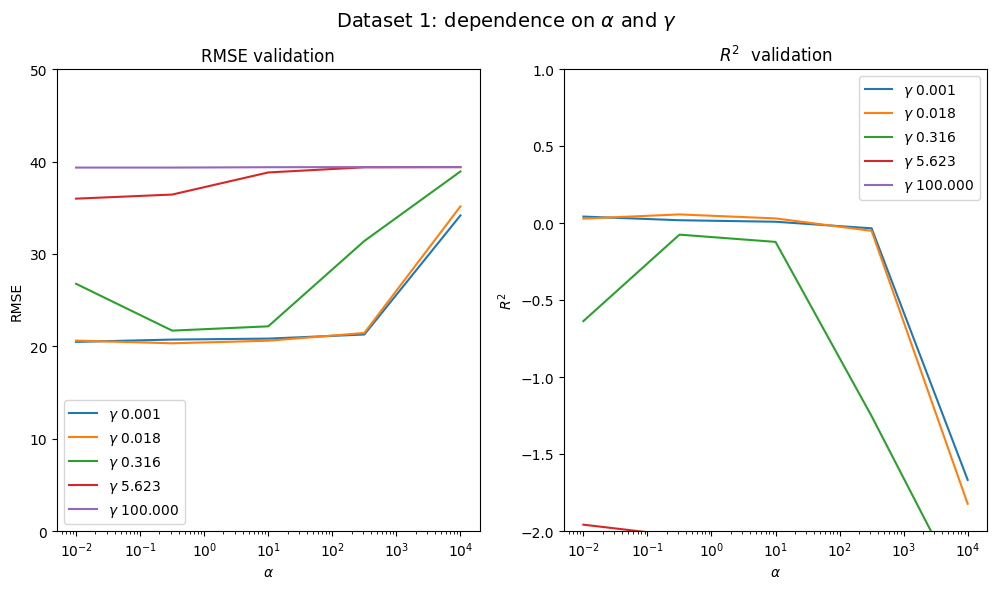

In [75]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 6))
plt.suptitle('Dataset 1: dependence on 'r'$\alpha$ and 'r'$\gamma$', fontsize=14)

for ind, i in enumerate(gammas):
  # print("index:", ind,"value:",f"{i:.3f}")
  ax1.plot(alphas, score_RMSE_ts[ind], label=r'$\gamma$ ' + f"{i:.3f}")
  ax2.plot(alphas, score_R2_ts[ind], label=r'$\gamma$ ' + f"{i:.3f}")
ax1.legend()
ax1.set_xscale("log")
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel("RMSE")
ax1.set_ylim(0,50)
ax1.set_title("RMSE validation")

ax2.legend()
ax2.set_xscale("log")
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel(r'$R^2$')
ax2.set_ylim(-2,1)
ax2.set_title(r'$R^2$  validation')

plt.show()

In [76]:
# to print best values of hyper parameters gamma and alpha
RMSE_min = score_RMSE_ts[score_RMSE_ts != 0].min()
print("Min RMSE = ",RMSE_min)
ij_min_idx = np.where(score_RMSE_ts == RMSE_min)
ij_min_idx = tuple([k.item() for k in ij_min_idx])
g_min_idx = ij_min_idx[0]
a_min_idx = ij_min_idx[1]
print("Max R^2 = ",score_R2_ts[ij_min_idx[0],ij_min_idx[1]])
gamma_best = gammas[ij_min_idx[0]]
alpha_best = alphas[ij_min_idx[1]]
print('best gamma =',f"{gamma_best:.4f}",'best alpha =',f"{alpha_best:.4f}")

Min RMSE =  20.32841125081562
Max R^2 =  0.05656340876721033
best gamma = 0.0178 best alpha = 0.3162


Same best parameters obtained also with Grid Search CV

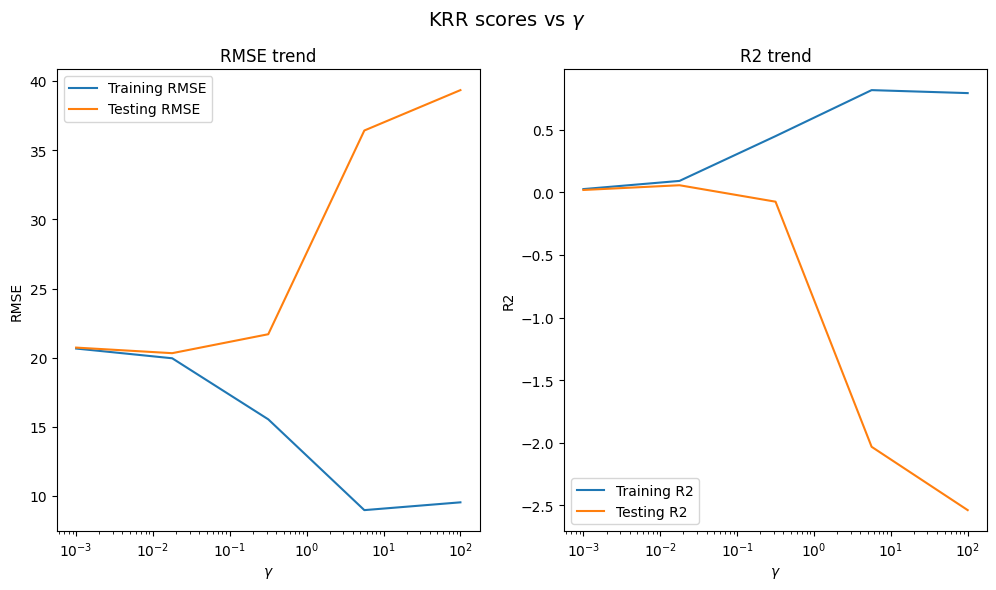

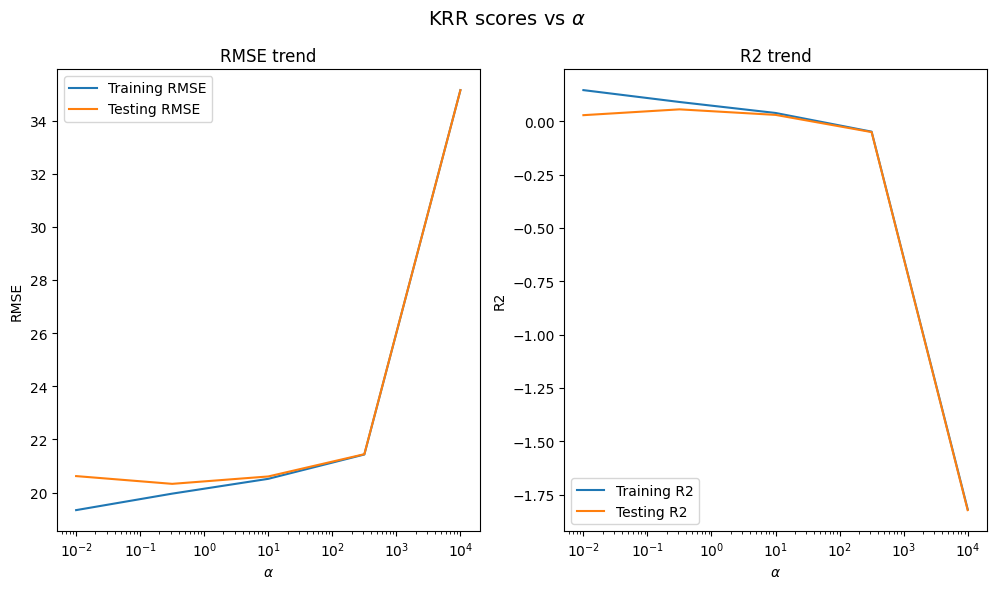

In [77]:
# considering fixed alpha_best --> index 1
title_1 = 'KRR scores vs 'r'$\gamma$'
varx_1 = r'$\gamma$'
plot_TrainTest_scores(score_RMSE_tr[:,a_min_idx],score_RMSE_ts[:,a_min_idx],score_R2_tr[:,a_min_idx],score_R2_ts[:,a_min_idx],gammas,title_1,varx_1)
# considering fixed gamma_best --> index 1
title_2 = 'KRR scores vs 'r'$\alpha$'
varx_2 = r'$\alpha$'
plot_TrainTest_scores(score_RMSE_tr[g_min_idx,:],score_RMSE_ts[g_min_idx,:],score_R2_tr[g_min_idx,:],score_R2_ts[g_min_idx,:],alphas,title_2,varx_2)

Compute results on test set

In [78]:
print("\nwith best parameters\n")

# perform kernel ridge regression on test set
sc1_train, sc1_test = KernelRidgeReg(X1K_train, y1K_train,X1K_test, y1K_test,gamma_best,alpha_best,False)
print("Score on test set",sc1_test)


with best parameters

Score on test set (20.564503126807747, 0.03819630811163621)
